# Predicting Incidence of Churn in Codeup-Telco Inc. Customers
-----
Project and Report Created By: Ray Zapata
<br><center><a href="https://ibb.co/P1m7dGK"><img src="https://i.ibb.co/wp09fhV/telecom.png" alt="telecom" border="0"></a></center><br>

We at Codeup-Telco Inc. strive to be the best in our industry, and we demonstrate that with a tradition of excellence in both service quality and customer relations. It's no secret that other providers give consumers a cheaper product, but it is just that—a cheaper product. We have to high of standards to provide just the barest of service, and it's up to us to ensure we provide just that to our valued customers.

This project serves a dual purpose. Firstly, we will be utilizing customer data to evaluate and analyze what it is that causes churn, thereby enabling us to predict future incidence of customer loss. Of course any reducttion in churn is a net gain to the bottom line, but what more than that? Within this report we will also find a way for us to improve even further the already quality products we provide, grow as a provider, and take even better care of our customers and their needs.


## Project Overview

---

This final report contains a high-level view into the project process and results, as well as our recommended actions and next phases. For additional insight into the [exploration](https://nbviewer.jupyter.org/github/ray-zapata/project_classification_telco/blob/main/exploration.ipynb) and [modeling](https://nbviewer.jupyter.org/github/ray-zapata/project_classification_telco/blob/main/modeling.ipynb) phase, the two notebooks linked here contain a more in-depth explanation of the process.

### Process

With this project we set to parse through existing customer data by first obtaining, preparing, and exploring it using python and it's various libaries. We will use custom modules to aid with this process as well as automate it for future replication. With this data, we will create several machine learning models which will be fit to a training dataset made up of $\approx60\%$ of total data. These models will then be evaluated with a smaller validation dataset comprised of $\approx20\%$ of the data, and finally the best performer will be used on a testing dataset also made up of $\approx20\%$ of the data.

With our final model, we will create a CSV document to contain `customer_id`, the unique indentifier for customers in our database, `prediction_of_churn`, a boolean value that shows if customer is predicted to churn $(1)$ or be retained $(0)$, and `probability_of_churn`, a float value that shows the predicted likelihood of customer churn.

### Goals

Our goal is to use the model created in the process above to find strong divers of churn and predict probability of customer loss. We will use this information to find remedies to these drivers and recommend action to set in place to reduce these areas of churn.

### Key Findings

In the exploration process of the project, we discovered several key variables related to customer churn. In visualizing the distribution of churn to retain customers, we found that signifcantly more customers with internet services churned than phone only customers. Customers in their first year of service were more likely to churn than customers who had passed their service anniversary. This lead us to look at specifically customers within their first year internet customers for the remaining process.

Of this subset of customers, the strongest positive correlation with churn was found with fiber optic customers, those who pay with electronic checks, and customers on month-to-month terms. These will be used as the features of our models.

### Recommended Action

As a leading provider of telecom services, our best course of action is in aiding our customers to find the right fit for their needs. Many customers may be considering cost-benefit of the services the subscribe to, and rather than have them churn, we can proactively reach out to high-risk customers in effort to find them satisfactory resolutions to their woes.

Fiber optic customers may not be seeing the performance they believe they should. We should reach out to these customer to see if they might be a better fit using our DSL service.

Customers paying with electronic checks may be experience complicatiions with this payment method. It is suggested that we analyze our payment systems to discover potential bugs that may be frustrating the process.

## Initalize Notebook

In [1]:
# import python libraries
import pandas as pd
import numpy as np

# import visualization tools
from matplotlib.pyplot import show
from sklearn.tree import plot_tree
import visualize as viz

#import created functions
from explore import explore_data
from prepare import prep_data, get_final_report
from model import baseline_model, tree_model, forest_model, knn_model, logit_model
from measure import two_sample_ttest, chi_test_lite, model_report, validate, final_test

# cosmetic imports and settings
import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import style
style.use('~/.matplotlib/gruvbox.mplstyle')
from end import end


## Obtain and Prepare Data for Exploration
---

### Data Acquisition and Preparation

Using the function `explore_data` defined in the explore module, we will create a pandas DataFrame containing all of our potential variables. This DataFrame will be acquired from the SQL database, cached as a CSV, encoded, and finally split into our $\approx60\%$ train dataset. For this function, and throughout this project, `random_state=19` will be used where applicable.

In [2]:
df = explore_data()


             Data Processing Complete
    +----------------------------------------+
    |   Source DataFrame Shape : 7043 x 27   |
    |   Subset DataFrame Shape : 4225 x 27   |
    |     Data Percentage Used : 59.99%      |
    +----------------------------------------+   
        


This data has had any potential duplicates removed, all missing values from the `total_charges` column filled with the mean, and holds only integers and float data types.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 5135 to 6339
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   is_female          4225 non-null   int64  
 1   is_senior          4225 non-null   int64  
 2   has_partner        4225 non-null   int64  
 3   has_dependent      4225 non-null   int64  
 4   has_phone          4225 non-null   int64  
 5   one_line           4225 non-null   int64  
 6   multiple_lines     4225 non-null   int64  
 7   has_internet       4225 non-null   int64  
 8   dsl                4225 non-null   int64  
 9   fiber              4225 non-null   int64  
 10  streaming_tv       4225 non-null   int64  
 11  streaming_movies   4225 non-null   int64  
 12  online_security    4225 non-null   int64  
 13  online_backup      4225 non-null   int64  
 14  device_protection  4225 non-null   int64  
 15  tech_support       4225 non-null   int64  
 16  monthly_charges    42

### Data Exploration

#### Initial Thoughts

- What role does `tenure` play in customer churn?
  - It seems reasonable that if you stay longer, you stay because you at satisfied.
- Do customers who churn have higher `monthly_charges` than customers who remain?
  - Reductive reasoning suggests if you can get it cheaper somewhere else, you will.
- Are particular services, like `dsl` or `fiber`, more likely to result in churn?
  - Maybe there is an issue with one of the services provided.
 


In exploration, it was found that most churn occured early on in customer tenure, and it was decided we would look at predicting churn with those first-year customers. In name of brevity, exploration through this report will begin with that assumption and using key features as determined in the same process. For more thorough exploration, please refer to the exploration notebook linked in first section of the project overview.

In [4]:
# create list of features to pass into function for DataFrame column creation
features = ['has_internet', 'fiber', 'monthly_charges', 'electronic_check', 'no_contract', 'tenure']

# reassign our DataFrame
df = explore_data(columns=features)

# split data into first and post years customers
first_year = df[df.tenure <= 12]
post_year = df[df.tenure > 12]


             Data Processing Complete
    +----------------------------------------+
    |   Source DataFrame Shape : 7043 x 7    |
    |   Subset DataFrame Shape : 4225 x 7    |
    |     Data Percentage Used : 59.99%      |
    +----------------------------------------+   
        


### Distribution

What can we discern by looking at the distrubition of variables in the customer population? We will use the `hist_vars` function from the visualize module to create some histograms of the variables we've selected.

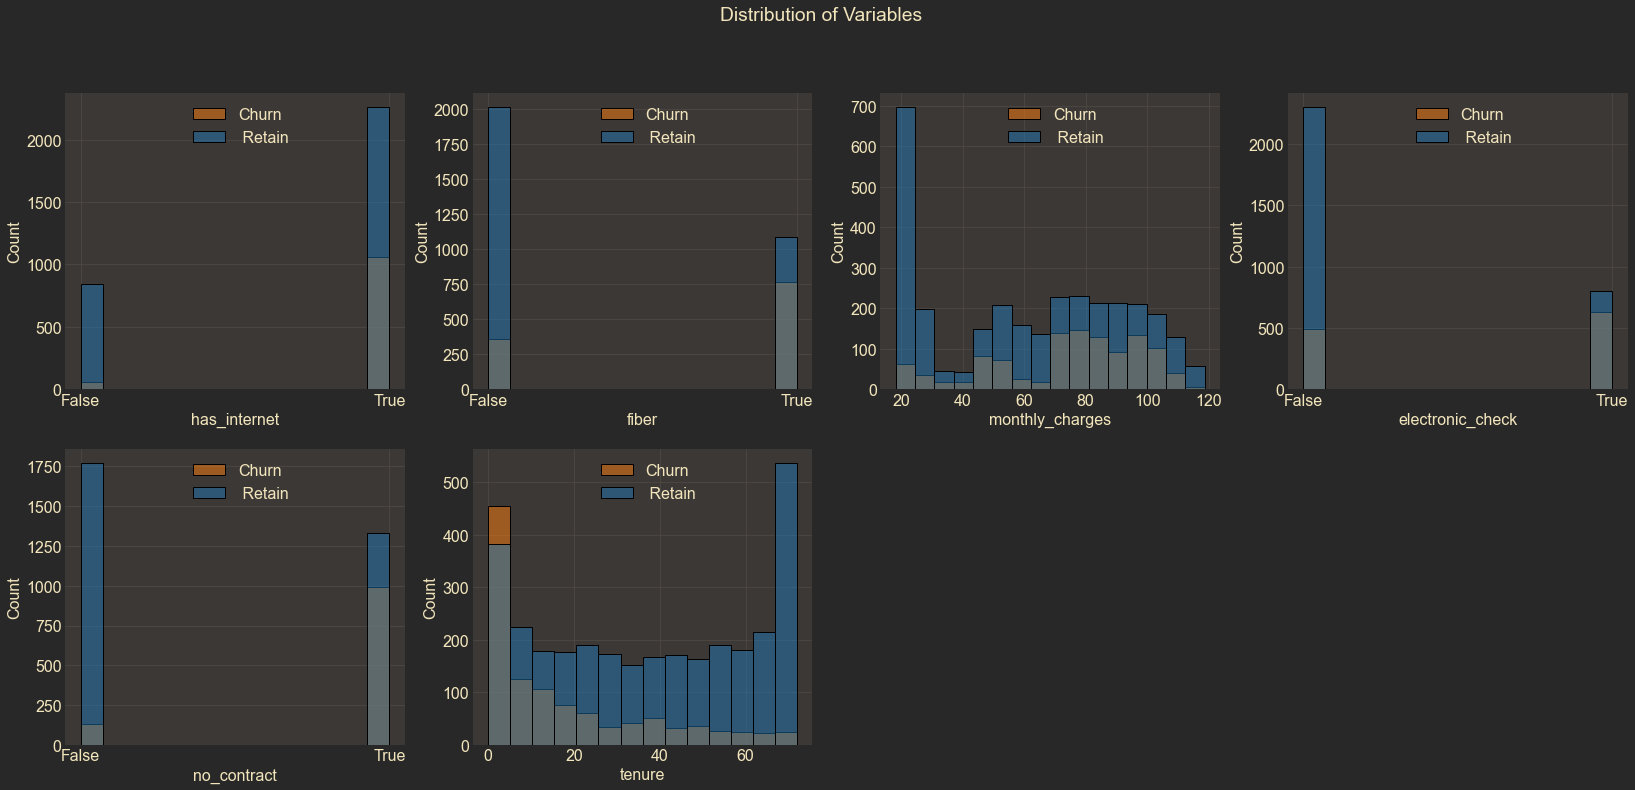

In [5]:
viz.hist_vars(df)

There are two very prominent takeaways from this visual. Customers who are month-to-month churn significantly more than our contract customers, and there is a steep decline in churn in tenure after the between the first and second five months. This is a pretty strong answer to our question in regard to `tenure`'s impact on churn.

There is also some significant disparity between phone-only customers who churn and customers with internet. From this we will get the best results by looking at what is causing our internet customers to churn.

### Correleation

This seaborn heatmap allows view the correleation of our variables to churn. We are from here going to be looking at first-year internet customers. Darker reds will indicate a stronger positive correlation, and darker blues will indicate a stronger negative correlation. The coeffecient will be annoted for improved carity,

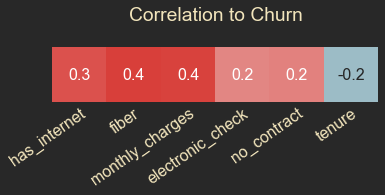

In [6]:
viz.heater(first_year)

We can see some moderately strong releationships between to churn with the heatmap. Unsurprisingly, as customer tenure increases, churn rates decrease. `no_contract` doesn't seem to be as strong as might be expected, but it is still a factor to consider. `fiber` still seems to be the strongest player in the game.

### Internet Customer Breakdown

We should inspect some hard numbers of fiber optic customers. Let's use this function to find our total customers, break them down by tenure as one year or over one year, and see our churn rate.

In [7]:
viz.internet_breakdown(df)


         Total Fiber Customers: 1851
+ ------------------------------------------ +
|                                            |
|   First Year Fiber Customers: 559          |
|                                            |
|                      Churned: 385          |
|                      Percent: 68.87%       |
|                                            |
|    Post Year Fiber Customers: 1292         |
|                                            |
|                      Churned: 379          |
|                      Percent: 29.33%       |
|                                            |
+ ------------------------------------------ +



Those are telling numbers. Fewer total fiber customers churn after their first year than in it. There must be something with this line of service that must be investigated.

### Statistical Testing

Now that we have some visuals to set our course, let us assess the relationships to churn using some statsitical testing. 

#### T-Test of Monthly Charges

We can divide up our data into two populations for comparison with monthly charges. Do customers who churn pay more than customers who are retained?

We will formulate our null and alternative hypotheses:

* H$_0$: There is no significant difference in monthly charges between customers who churn and customers retained.
* H$_a$: There is a  significant difference in monthly charges between custoemrs who churn and customers retained.

And define our `alpha`, or significance level:

* $\alpha$: 0.05

In [8]:
# define our a and b populations for ttest
ab = df[(df.fiber == 1) & (df.tenure <= 12)]
a = ab[ab.churn == 1].monthly_charges
b = ab[ab.churn == 0].monthly_charges

In [9]:
# run two_sample_ttest function for one-tail
two_sample_ttest(a, b, alternative='greater')


  alpha: 0.05
p-value: 0.009

        Due to our p-value of 0.009 being less than our significance level of 0.05, we must reject the null hypothesis
        that there is no difference in monthly_charges between the two populations.
        


#### $\chi^2$ Test of Categorical Features

In order to compare our other categorical variables to our categorical target, we can perform some $\chi^2$ tests to evaluate their independence from eachother. For brevity and space, we will use a function to take in our variables against our target to output our p-value and whether to accept or to reject the null hypothesis. To see the resulting `expected` DataFrame please see the exploration notebook. 

Again state our null and alternative hypotheses:

- H$_0$: Churn is indepdenent of the compared variable.
- H$_a$: Churn is not indepdenent of the compared variable.

And define our significance level:
- $\alpha$: 0.05

In [10]:
# set list of categorical features for chi_square test
v_cats = ['has_internet', 'fiber', 'electronic_check', 'no_contract']

In [11]:
# loop chi_square through features chosen for model stage
# to determine whether to accept or reject null hypotheses
for cat in v_cats:
    chi_test_lite(df[cat], df.churn)


  alpha: 0.05
p-value: 4e-52

        Due to our p-value of 4e-52 being less than our significance level of 0.05, we must reject the null hypothesis
        that churn is independent of has_internet.
        

  alpha: 0.05
p-value: 1e-81

        Due to our p-value of 1e-81 being less than our significance level of 0.05, we must reject the null hypothesis
        that churn is independent of fiber.
        

  alpha: 0.05
p-value: 4e-76

        Due to our p-value of 4e-76 being less than our significance level of 0.05, we must reject the null hypothesis
        that churn is independent of electronic_check.
        

  alpha: 0.05
p-value: 4e-152

        Due to our p-value of 4e-152 being less than our significance level of 0.05, we must reject the null hypothesis
        that churn is independent of no_contract.
        


## Machine Learning Model
---

When creating our inital models in the modeling notebook, four models were create for each of the standard `sklearn` classification models. In this report we will walk through the creation of the baseline and best performing model, and finally test our model using the `test` dataset. When creating a model, it was decided it would be best to optimize for recall of the positive class as a false negative was determined to be more harmful to the intent of the model than a false positive. In this case, a positive case was defined as `churn==1` with the negative case being `churn==0`. Below we will recreated the best performing `LogisticRegression` model and see how well it performs on our test.

#### Prepare Data

In [12]:
# assign out X, y for each dataset to be used in creation, evaluation, and testing
X_train, y_train, X_validate, y_validate, X_test, y_test = prep_data(columns=features)

#### Baseline

We will create a baseline prediction using the most frequently occuring class in our target. The `baseline_model` function will take in our `X_train` DataFrame and `y_train` series and automatically return a `DummyClassifier` with that class.

In [13]:
# assign baseline model and predictions, output accuracy score and values held
baseline, baseline_pred = baseline_model(X_train, y_train)


               Baseline Accuracy Score: 73.47%
        First Ten Baseline Predictions: [0 0 0 0 0 0 0 0 0 0]
        


We can see our baseline accuracy score output printed by the function, as well as the first ten values held in its "predicitons."

#### Model Creation

Next we will use the `logit_model` function to create a new `LogisticRegression` model using `solver='liblinear` to account for data size and `class_weight={0:1.1, 1:1.7}` to adjust for class imbalance in our target variable.

In [14]:
# assign model and model predictions on training dataset, output model performance
logit, logit_pred = logit_model(X_train, y_train, solver='liblinear', class_weight={0:1.1, 1:1.7})

# print baseline accuracy for comparison
print(f'Baseline Accuracy: {baseline.score(X_train, y_train):.2%}\n')


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: Churn  (1)        |
|            Negative Case: Retain (0)        |
|---------------------------------------------|
|                 Accuracy:   78.06%          |
|       True Positive Rate:   42.07%          |
|      False Positive Rate:   22.16%          |
|       True Negative Rate:   77.84%          |
|      False Negative Rate:   57.93%          |
|                Precision:   57.65%          |
|                   Recall:   65.21%          |
|                 F1-Score:   61.20%          |
|                                             |
|         Positive Support:     1121          |
|         Negative Support:     3104          |
|            Total Support:     4225          |
|_____________________________________________|

Baseline Accuracy: 73.47%



Using our function, we get an automatic print of the model's metrics. We can see with an accuracy score of $\approx79\%$, we have surpassed the baseline accuracy score. What's more, we are hitting nearly $68\%$ recall score for the positive class. This was the best result we had obtained in model creation.

#### Model Evaluation
Now that we've seen our baseline and model on the training data, we can evaluated it using our validation dataset and see how it performs on out-of-sample data.

In [15]:
# assign model predictions on validation dataset, output model performance
logit_val_pred = validate(X_validate, y_validate, logit)

# print baseline accuracy for comparison
print(f'Baseline Accuracy: {baseline.score(X_validate, y_validate):.2%}\n')


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: Churn  (1)        |
|            Negative Case: Retain (0)        |
|---------------------------------------------|
|                 Accuracy:   78.64%          |
|       True Positive Rate:   45.18%          |
|      False Positive Rate:   21.48%          |
|       True Negative Rate:   78.52%          |
|      False Negative Rate:   54.82%          |
|                Precision:   59.06%          |
|                   Recall:   63.64%          |
|                 F1-Score:   61.26%          |
|                                             |
|         Positive Support:      374          |
|         Negative Support:     1035          |
|            Total Support:     1409          |
|_____________________________________________|

Baseline Accuracy: 73.46%



Once again, our function automatically gives a printout of the performance on the dataset. Our accuracy score, while slightly higher, is not alarmingly so. One thing to note is we do have a decrease of around three percentage points in our recall. It still performed better than the other models did on both validation and training datasets, however.

## Final Test

Lastly, we come to the make-or-break moment of testing. This is the only model to make it to this stage, as the other model performance was outclasses by our logit model we have been working with here. Without further ceremony...

In [16]:
# assign model predictions on test dataset, output model performance
logit_test_pred = final_test(X_test, y_test, logit)

# print baseline accuracy for comparison
print(f'Baseline Accuracy: {baseline.score(X_test, y_test):.2%}\n')


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: Churn  (1)        |
|            Negative Case: Retain (0)        |
|---------------------------------------------|
|                 Accuracy:   78.50%          |
|       True Positive Rate:   42.90%          |
|      False Positive Rate:   22.06%          |
|       True Negative Rate:   77.94%          |
|      False Negative Rate:   57.10%          |
|                Precision:   58.51%          |
|                   Recall:   65.24%          |
|                 F1-Score:   61.69%          |
|                                             |
|         Positive Support:      374          |
|         Negative Support:     1035          |
|            Total Support:     1409          |
|_____________________________________________|

Baseline Accuracy: 73.46%



Just like that, it was done. We can see performance has decently been retained, and we are still capturing over $65\%$ of the positive class. Even at the final stage, this model out performs both the baseline and our other models in the previous stages. With this model, we can look at the probability output and use it to assign customers into a high-risk of churn category. With a proactive approach, many of these customers may be retained.

## Conclusion
---

### Summation

In this report we demonstrated how the data was prepared, how it was explored, and the manner in which a model for prediction was constructed. We found that the strongest drivers of increased churn related to low tenure, fiber optic internet service, payment by electronic check, and month-to-month terms.

Here are the key points to take from this report:
- Customer churn drops significantly after the first five months.
- Fiber optic customers churn $69\%$ in their first year, relative to $29\%$ after.
- First year fiber customers paid statstically significantly more than post year fiber customers
- Month-to-month term customers churn at close to the same rate they are retained

With our model were were able to succesfully capture nearly $64\%$ of positive cases of churn in our testing dataset. This model has room to improve, but by reaching out to those customers, we have the capability of a significan increase in customer retention.

This report has given a high-level view of the data science pipeline from acquiring through evaluation. Now we can output our predictions and their probability as deduced by our model, delivering our prediction report. This function will output to a CSV file that will contain three columns:
- `customer_id`: Unique identifier of the customer in the database
- `probability_of_churn`: Percentage float of the likelihood the prediction is accurate
- `prediction_of_churn`: Boolean value that is $1$ if churn was predicted to occur

In [17]:
get_final_report(logit, features, cache=True)

,customer_id,probability_of_churn,prediction_of_churn
0,0016-QLJIS,0.05,0
1,0017-DINOC,0.06,0
2,0019-GFNTW,0.06,0
3,0056-EPFBG,0.17,0
4,0078-XZMHT,0.04,0
...,...,...,...
7038,9962-BFPDU,0.25,0
7039,9967-ATRFS,0.15,0
7040,9970-QBCDA,0.22,0
7041,9975-SKRNR,0.25,0


### Recommended Actions and Further Development

Knowing that our strongest drivers of churn being the allowance of month-to-month terms, this seems to be a good area to focus on altering. Codeup-Telco has no plans to require contractual obligations to be customers, such an act would likely be harmful and result in further customer loss. What we are recommending instead is to offer incentives and promotional discounts in exchange for term agreements.

Due to the varied nature of internet usage, it is possible many of our fiber customers churn due dissatisfaction with the speeds, latency, and stability they experience, not understanding the role servers and media not owned and operated by Codeup-Telco play in that unexpected performance. With regard to payment methods, the high correlation between customers paying with electronic checks and churn warrants inspecting of our payment systems to route out potential bugs or flaws that may complicate or obfuscate the process.

By offering customers trial periods of our streaming TV and movies for agreeing to one- or two-year terms, it is possible to incentivise customers into remaining longer, and possibly even continue subscriptions to one or both of those services after the trial. Once customers have completed the term for their contracts, the data suggests they are likely to remain customers longer.

The next logical phase in aiding unhappy customers is by directly reaching out to help resolving the dilemmas they may be facing in usage of our provided services. Using our model probability for churn, we can reach out to those customers indicated to likely churn with surveys, hear directly what they have to say, and offer them courtesy promotions to thank them for their continuing patronage.

In [18]:
end()


































 

































 

































 Giga... Drill.. BREAK!!
